In [1]:
%pylab inline
pylab.rcParams['figure.figsize'] = 12,5

Populating the interactive namespace from numpy and matplotlib


Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 30 days


In [2]:
# This script will parse a CSV file taken from the Spectre Simulations and extract out the Early Voltage
import os
import sys
from scipy.optimize import leastsq
from pylab import *
import csv
import mpld3
from IPython.display import Image
from ipywidgets import interact, interactive, FloatSlider, Dropdown

This notebook will be used to extract various transistor properties from simulation, based on the All-Region MOSFET Model described in Schneider and Galup-Montoro's book.  As such, the parameters are with reference to how they are defined in this book.

# General functions

In [3]:
# This function reads a csv file and returns the raw data from the file,
# excluding the first line.  It will return the raw data as two lists: the first
# list will have the xVals, and the second array will have the yVals.
def readFile(filePath):
    data = genfromtxt(filePath, dtype=float, delimiter=",", skip_header=1)
    xVals = data[:,0::2]
    yVals = data[:,1::2]
    return xVals, yVals

# A function that allows the end-user to specify the type of plot he/she wants 
# to retrieve by various parameters.  Essentially, this is a wrapper on the 
# readFile function above.
def getData(folderRoot, FETType="NFET_eg1L", CurveType="IdsVgs", IDVal="_Vds0.1", printFN=False):
    fN = folderRoot + FETType + "_" + CurveType + "_" + IDVal + ".csv"
    if printFN:
        print fN
    xVals, yVals = readFile(fN)
    return xVals, yVals

# UT calculates the thermal voltage as a function of temperature (in Celsius), the value of
# electronic charge, and Boltzmann's constant.
def UT(degC):
    _k = 1.3806503e-23
    _q = 1.60217646e-19
    return(_k*(273.15+degC)/_q)

## Fitting algorithm functions

In [4]:
# fitLine takes data organized as columns of x,y pairs of data, and sorts through the columns to fit a line to each
# column's worth of data.  It returns an array for each output variable, m and b.  Each output array is of length = 
# number of columns
def fitLine(data):
    Xs, Ys = data
    ms = list()
    bs = list()
    numCols = shape(Ys)[1]
    for i in range(numCols):
        popt,pcov = leastsq(linFitErr, (0.00002, 0.00005), args=(Xs, Ys.T[i]))
        #print popt
        ms.append(popt[0])
        bs.append(popt[1])
    return array(ms), array(bs)

# linFit gets plots a line with slope m, and y-intercept b
def linFit(x, m, b):
    return m*x + b

# linFitErr calculates the difference between some data and a theoretical line with slope m, and
# y-intercept b.
def linFitErr(x0s, xData, yData):
    (m,b) = x0s
    return yData - linFit(xData, m, b)

# getEarlyVoltages finds the slope and y-intercept of the line that best fits the data
# for x-values above "threshold"
def getEarlyVoltages(origVds, origIds, threshold):
    mask = origVds>threshold
    if len(mask)<1:
        print "WARNING: Threshold might be set too high"
    ev_Vds = origVds[mask]
    ev_Ids = origIds[mask]
    
    Ms, Bs = fitLine((ev_Vds,ev_Ids))
    EarlyVoltages = calcEV(Ms, Bs)
    print "Early Voltages:\t", EarlyVoltages
    
    return (ev_Vds, ev_Ids, EarlyVoltages, Ms, Bs)

# calcEV takes the slope and y-intercept of a line and uses that to calculate the x-intercept.
# This allows the user to fit a linear line and calculate the Early Voltage from that.
def calcEV(m, b):
    return -b/m

## Plotting functions

In [5]:
fntSz = 16
def plotIds(data, ttl="", xlbl="", ylbl="$I_d (A)$", color=(1,0,0)):
    Xs, Ys = data
    # Determine whether or not there are multiple columns worth of (x,y) plots.
    # If so, color code the plots from blue to red, otherwise, use the input color
    if len(shape(Ys))<=1:
        plot(Xs, Ys, '.', color=color)
    else:
        numCols = shape(Ys)[1]
        for i in range(numCols):
            plot(Xs, Ys.T[i], '.', color=(1.*i/(numCols-1), 0, 1.-(1.*i/(numCols-1))))
        
    xlabel(xlbl, fontsize=fntSz)
    ylabel(ylbl, fontsize=fntSz)
    ylim([0,Ys.max()*1.1])
    title(ttl)

def plotlogIds(data, ttl="", xlbl="", ylbl="$I_d (A)$", color=(1,0,0)):
    Xs, Ys = data
    # Determine whether or not there are multiple columns worth of (x,y) plots.
    # If so, color code the plots from blue to red, otherwise, use the input color
    if len(shape(Ys))<=1:
        semilogy(Xs, Ys, '.', color=color)
    else:
        numCols = shape(Ys)[1]
        for i in range(numCols):
            semilogy(Xs, Ys.T[i], '.', color=(1.*i/(numCols-1), 0, 1.-(1.*i/(numCols-1))))
            
    xlabel(xlbl, fontsize=fntSz)
    ylabel(ylbl, fontsize=fntSz)
    ylim([Ys.min()/10, Ys.max()*10])
    title(ttl)
    
def plotEarlyVTheory(Vds, Ms, Bs, minX=-30.):
    #print "Slopes: ", Ms
    #print "Intercepts: ", Bs
    for i in range(len(Ms)):
        thIds = linFit(Vds, Ms[i], Bs[i])
        plot(Vds, thIds, "b.")
        thLineXs = arange(minX, max(Vds), 0.01)
        thIdLine = linFit(thLineXs, Ms[i], Bs[i])
        plot(thLineXs, thIdLine, "b--")
    xlims = [minX*1.05, max(Vds)]
    ylims = [0, max(thIdLine)*1.1]
    xlim(xlims)
    ylim(ylims)

In [6]:
def plotVgPlots(Vgs, Ids, ttl, color=(1,0,0)):
    gms = calcGm(Vgs, Ids)
    #print "gms", gms
    gmOverId = calcGmOverId(gms, Ids[:-1])
    #print "gm/Id", gmOverId
    
    Vth, half_gmOverId = calcVth(Vgs, gmOverId)
    ISVal = calcIS(Vth, Vgs, Ids)
    
    subplot(1,3,1)
    plotlogIds((Vgs, Ids), ttl=ttl, xlbl=r'$V_{gs}$', color=color)
    # Use the threshold voltage calculated to plot a vertical line in the plot
    vlines(Vth, Ids.min()/10, Ids.max()*10,
           colors=color,
           linestyles='dashed')

    subplot(1,3,2)
    plotlogIds((Vgs[:-1], gms), 
               ttl=r'$g_m$ '+ttl, xlbl=r'$V_{gs}$', ylbl=r'$g_m$', color=color)
    
    subplot(1,3,3)
    plotIds((Vgs[:-1], gmOverId), 
               ttl=r'$g_m/I_{ds}$ '+ttl, xlbl=r'$V_{gs}$', ylbl=r'$g_m/I_{ds}$', color=color)
    # Use the threshold voltage calculated to plot a vertical line in the plot
    hlines(half_gmOverId, 0, 1,
           colors=color,
           linestyles='dashed')
    vlines(Vth, gmOverId.min()/10, gmOverId.max()*10,
           colors=color,
           linestyles='dashed')

    tight_layout()

    return Vth, ISVal, gms, gmOverId

In [7]:
def plotVpvsVg(data, ttl="", color=(1,0,0), fntSz=12):
    Xs, Ys = data
    
    # Determine whether or not there are multiple columns worth of (x,y) plots.
    # If so, color code the plots from blue to red, otherwise, use the input color
    if len(shape(Ys))<=1:
        #print "plotting only one dataset"
        plot(Xs, Ys, '-', color=color)
    else:
        #print "plotting multiple datasets"
        numCols = shape(Ys)[1]
        for i in range(numCols):
            plot(Xs, Ys.T[i], '-', color=(1.*i/(numCols-1), 0, 1.-(1.*i/(numCols-1))))
    #numCols = shape(Ys)[1]
    #for i in range(numCols):
    #    plot(Xs[1:], dYs/dXs, '.', color=color)
    xlabel(r'$V_{g}$', fontsize=fntSz)
    ylabel(r'$V_{p} (V_s)$', fontsize=fntSz)
    #ylim([Ys.min()/10, Ys.max()*10])
    title(ttl)
    
def plotSlopeFactor(data, ttl="", color=(1,0,0), fntSz=12):
    Xs, Ys = data
    dYs = diff(Ys)
    dXs = diff(Xs)
    plot(Xs[:-1], dXs/dYs, '.', color=color)
    xlabel(r'$V_{g}$', fontsize=fntSz)
    ylabel(r'$n (1/\kappa)$', fontsize=fntSz)
    #ylim([Ys.min()/10, Ys.max()*10])
    title(ttl)
    return dXs/dYs

# This function plots the 1/(n-1)^2 data vs Vps
# Input to this function are two arrays, Vps and Ns
def plotSFParamData(data, ttl="", color=(1,0,0), fntSz=12):
    Xs, Ns = data
    Ys = calcInvNOffSq(Ns)
    
    plot(Xs, Ys, '.', color=color)
    xlabel(r'$V_{p}$', fontsize=fntSz)
    ylabel(r'$1/(n-1)^2$', fontsize=fntSz)
    #ylim([Ys.min()/10, Ys.max()*10])
    title(ttl)
    return Ys

## Extraction functions

In [8]:
# calculate transcondutance if given two arrays, Vg values and Id Values, respectively
# Note: if the arrays are multidimensional, they should be arranged so that each
#     row corresponds to the array of Vg or Id values, respectively.
def calcGm(Vgs, Ids):
    return abs(diff(Ids))/diff(Vgs)

# Takes gms and Ids and returns an array of gm/Id
#    gms: array of transconductances
#    Ids: array of Id values
# Note: these two arrays must be of the same size.
def calcGmOverId(gms, Ids):
    return gms/Ids

# This function takes the gmOverId values and the Vgs values and returns Vth
#    Vgs: array of gate voltages corresponding to the gm/Id values
#    gmOverID: array of gm/Id values
def calcVth(Vgs, gmOverId):
    # Calculate the threshold voltage from the last plot's data
    half_gmOverId = gmOverId.max(axis=0)*0.53  #from S&GM, p.462, footnote 1
    #print "Half of max(gm/Id ratio):", half_gmToIdRatio
    
    if gmOverId[0]>gmOverId[-1]:   # FETType is an NFET
        Vth = Vgs[where(gmOverId>=half_gmOverId)][-1]
    else:    # FETType is a PFET FETType=="P"
        Vth = Vgs[where(gmOverId>=half_gmOverId)][0]
    #print "Vth: ", Vth
    return Vth, half_gmOverId
    

# This function takes a threshold voltage and two arrays as arguments
#    Vth: threshold voltage
#    Vgs: array of gate voltages corresponding to the Id values
#    Ids: array of Id values
# Returns the specific current for this transistor, at Vth.
# Note the returned value may be an array if the input Vgs and Ids values are 
# multi-dimensional (MxN) arrays.  If this is the case, end-user must be sure to
# grab the correct values that he/she wants from the result N-element long array
def calcIS(Vth, Vgs, Ids):
    
    Vth_idx = where(Vgs[:]==Vth)
    #print "Vth_idx:", Vth_idx
    #print Ids[Vth_idx], Ids[Vth_idx][0]
    IS = Ids[Vth_idx]*1.13 # from S&GM, p.462, Footnote 1
    #print "IS Val: ", IS
    return IS

In [9]:
# This function will take a scalar value of a drain current and return the
#   corresponding V (Vg or Vd) value for it.
#   The V Val returned is based on the curveType of the plot
# IVal: scalar
# VVals: 1D Array of voltage values
# IVals: 1D Array of current values
def getVVal(IVal, VVals, IVals):
    #print "Mean of difference: ", mean(diff(yVals[:,i]))
    if mean(diff(IVals))<0:  # implies that Ivals decrease as Vvals increase
        #print "Device is PFET"
        Vg = VVals[where(IVals<=IVal)[0][0]]
    else:
        #print "Device is NFET"
        Vg = VVals[where(IVals<=IVal)[0][-1]]
    #print Vg
    return Vg

# This function will take a scalar value of a voltage and return the
#   drain current  I value corresponding to it
# VVal: scalar value (either Vg or Vd)
# VVals: 1D Array of voltage values
# IVals: 1D Array of current values
# Note: This function assumes that VVals is always smallest to largest (sorted)
def getIVal(VVal, VVals, IVals):
    Id = IVals[where(VVals<=VVal)[0][-1]]
    #print Id
    return Id

In [10]:
def compareFETs(FETTypes, folderRoots, ttl, curveType="IdsVgsCurve", printFN=False):
    FETType1, FETType2 = FETTypes
    folderRoot1, folderRoot2 = folderRoots
    
    numTemps = len(temps)
    maxY = 0
    
    Vths1 = list()
    ISs1 = list()
    Vths2 = list()
    ISs2 = list()
    
    for i, curTemp in enumerate(temps):
        Vd = Vds[i]
        #print 
        print "Temp:", curTemp, "\tVds:", Vd

        Vgs1, Ids1 = getData(folderRoot1, FETType=FETType1,
                                                CurveType=curveType, IDVal="Vds"+str(Vd), printFN=printFN)
        Vgs2, Ids2 = getData(folderRoot2, FETType=FETType2,
                                                CurveType=curveType, IDVal="Vds"+str(Vd), printFN=printFN)

        Vth1, IS1, gms1, gmOverId1 = plotVgPlots(Vgs1[:,i], Ids1[:,i],
                                        ttl=ttl, color=(1.*i/(numTemps-1), 0, 1-(1.*i/(numTemps-1))))
        #print "Vth1:\t", Vth1, "\nIS1:\t", IS1
        Vths1.append(Vth1)
        ISs1.append(IS1[0])    

        Vth2, IS2, gms2, gmOverId2 = plotVgPlots(Vgs2[:,i], Ids2[:,i],
                                        ttl=ttl, color=(1.*i/(numTemps-1), 0.5, 1-(1.*i/(numTemps-1))))
        #print "Vth2:\t", Vth2, "\nIS2:\t", IS2
        Vths2.append(Vth2)
        ISs2.append(IS2[0])

        maxY = max( [maxY, 1.1*max( gmOverId1.flatten() ), 1.1*max( gmOverId2.flatten() )] )
        #print "Max Y:", maxY
        ylim((0,maxY))
        
    print "Vth (",FETType1,"):", Vths1, "\nVth (",FETType2,"):", Vths2
    print "IS (",FETType1,"):", ISs1, "\nIS (",FETType2,"):",ISs2
    
    return Vths1, ISs1, Vths2, ISs2

In [28]:
def calcInvNOffSq(N):
    return 1./((N-1)**2)

def calcN(invNOffSq):
    return sqrt(1./invNOffSq)+1

def SFParamEq(xData, gamma, phiF):
    invNOffsetSq = (1/(gamma**2))*((4*xData) + (8*phiF))
    return invNOffsetSq

# This function returns the residual to fitting the slope factor equation
# (as a function of gamma and phiF)
def SFParamEq_res(params, yData, xData):
    gamma, phiF = params
    err = yData - SFParamEq(xData, gamma, phiF)
    return err

def getSFParams(Vps, invNOffSqs, p0):
    #print len(Vps), Vps
    #print len(invNOffSqs), invNOffSqs
    #Ys = 1/((Ns-1)**2)
    params = leastsq(SFParamEq_res, p0, args=(invNOffSqs, Vps))
    #Once we have scipy ver 18+, this following bouded least square operation will work
    #params = least_squares(SFParamEq_res, p0, args=(invNOffSqs, Vps), bounds=((-inf, inf), (-1,1)))
    #print params[0]
    gamma, phiFermi = params[0]
    #print "Fitted Gamma:", gamma, "\t Fitted V_fermi:", phiFermi
    return gamma, phiFermi

def slopeFactor(folderRoot, FETType="NFET", curveType="VgvsVs_KappaExtraction",
                temps=[25], ttl=None, xLims=(0,1), yLims=None, printFN=False, plotIdx=0):
    numTemps = len(temps)
    SFs = list()
    gammas = list()
    vFermis = list()
    j = plotIdx
    if ttl==None:
        ttl = FETType
        
    for i, curTemp in enumerate(temps):
        #print
        #print "Temp:", curTemp

        Vps, Vgs = getData(folderRoot, FETType=FETType,
                           CurveType=curveType, IDVal="T"+str(int(curTemp))+"C", printFN=printFN)
        # Plot of pinch-off voltage vs gate voltage
        subplot(1,3,1)
        plotVpvsVg((Vgs[:,j+1], Vps[:,j]), ttl="$V_p vs V_g$: "+ttl,
                    color=(1.*i/(numTemps-1), 1.*j/(numTemps-1), 1-(1.*i/(numTemps-1))), fntSz=14)
        xlim(xLims)

        # Plot of slope factor vs Vgs
        subplot(1,3,2)
        curSFs = plotSlopeFactor((Vgs[:,j+1], Vps[:,j]), ttl="$n (1/\kappa)$: "+ttl,
                    color=(1.*i/(numTemps-1), 1.*j/(numTemps-1), 1-(1.*i/(numTemps-1))), fntSz=14)
        xlim(xLims)
        ylim(yLims)
        #print array(curSFs)
        SFs.append(array(curSFs))
        
        # Plot of 1/(n-1)^2 vs Vp curve
        subplot(1,3,3)
        #print curSFs
        Ns = array(curSFs)
        if xLims!=None:
            mask = where((Vgs[:,j+1]>=min(xLims))*(Vgs[:,j+1]<max(xLims)))[0]
        else:
            mask = where((Vgs[:,j+1]>=min(Vgs[:,j+1]))*(Vgs[:,j+1]<max(Vgs[:,j+1])))[0]
        gamma, phiFermi = getSFParams(Vps[mask,0], calcInvNOffSq(Ns)[mask], (0.5, 0.5))
        gammas.append(gamma)
        vFermis.append(phiFermi)
        #print "Extracted Gamma, and FermiV:", gamma, phiFermi
        #print shape(Vps[mask,0]), shape(Ns[mask])
        plotSFParamData((Vps[mask,j], Ns[mask]),
                        ttl="$1/(n-1)^2$ vs Vp: "+ttl,
                        color=(1.*i/(numTemps-1), 1.*j/(numTemps-1), 1-(1.*i/(numTemps-1))),
                        fntSz=14)
        
        plot(Vps[mask,j],SFParamEq(Vps[mask,j], gamma, phiFermi),'--',
                       color=(1.*i/(numTemps-1), 1.*j/(numTemps-1), 1-(1.*i/(numTemps-1)),0.5))
    tight_layout()
    # Returns the average slope factor value
    return array(SFs), array(gammas), array(vFermis)

# Note: SFs should have the same number of dimensions as temps has length
def printSFData(temps, SFs):
    for i, curSFs in enumerate(SFs):
        print "Temp: ", temps[i]
        print "Mean SFs:", mean(array(curSFs)), "\tMean kappa:", mean(1/array(curSFs))
        print "Min SFs:", array(curSFs).min(), "\tMin kappa:", (1/array(curSFs)).min()
        print "Max SFs:", array(curSFs).max(), "\tMax kappa:", (1/array(curSFs)).max()
        
def printGammaData(gammas):
    print "Fitted Gammas:", gammas
    
def printFermiData(vFermis):
    print "Fitted V_fermis:", vFermis
    
def printSFInfo(temps, SFs, gammas, vFermis):
    printSFData(temps, SFs)
    printGammaData(gammas)
    printFermiData(vFermis)

# Get general data from the files

In [12]:
folderRoot = "/home/noza/work/Braindrop/CDB/BDTests/NFET_test/IV_Sim_Results/ParamExtract/"
folderRoot_P = "/home/noza/work/Braindrop/CDB/BDTests/PFET_test/IV_Sim_Results/ExtractParams/"

#paramFileName = folderRoot + "ParamAnalysisVals_VgSweep.csv"
#with open(paramFileName) as pfn:
#    reader = csv.reader(pfn)
#    data = list()
#    for i, row in enumerate(reader):
#        data.append(double(row[1:]))
#Vgs = data[0]
#print "Vg Vals:", Vgs
paramFileName = folderRoot + "ParamAnalysisVals_ohmicVdsTempSweep_IdVgsPlot.csv"
with open(paramFileName) as pfn:
    reader = csv.reader(pfn)
    data = list()
    for i, row in enumerate(reader):
        data.append(double(row[1:]))
#print data
Vds = data[0]
print "Vd Vals:", Vds
if len(data)>1:
    temps = data[1]
    print "Temp Vals:", temps

Vd Vals: [ 0.012  0.013  0.014]
Temp Vals: [  0.  25.  50.]


# Extract Parameters

## Plot $I_{ds}$ vs $V_{ds}$

NameError: name 'origVds_1L' is not defined

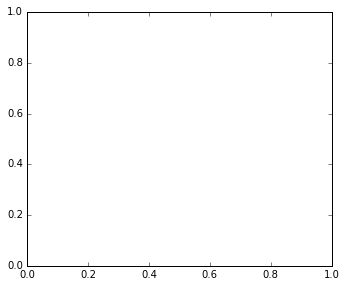

In [445]:
figsize(12,10)
subplot(2,2,1)
plotIds((origVds_1L, origIds_1L_Vds*1e6),
        ttl="Thin-FET, 1L, Varying $V_{gs}$", xlbl=r'$V_{ds}$', ylbl=r'$I_d (\mu A)$')
subplot(2,2,2)
plotIds((origVds_3L, origIds_3L_Vds*1e6),
        ttl="Thin-FET, 3L, Varying $V_{gs}$", xlbl=r'$V_{ds}$', ylbl=r'$I_d (\mu A)$')
subplot(2,2,3)
plotIds((origVds_eg1L, origIds_eg1L_Vds*1e6),
        ttl="Thick-FET, 1L, Varying $V_{gs}$", xlbl=r'$V_{ds}$', ylbl=r'$I_d (\mu A)$')
subplot(2,2,4)
plotIds((origVds_eg3L, origIds_eg3L_Vds*1e6),
        ttl="Thick-FET, 3L, Varying $V_{gs}$", xlbl=r'$V_{ds}$', ylbl=r'$I_d (\mu A)$')
tight_layout()
show()

## Plot $I_{ds}$, $g_m$, and $\frac{g_m}{I_{ds}}$ vs $V_{gs}$
From the transconductance-to-current plot, we'll be able to extract $I_S$ and $V_T$
### Thick-Oxide
#### Short Channel (1L, 150nm)

Temp: 0.0 	Vds: 0.012
Temp: 25.0 	Vds: 0.013
Temp: 50.0 	Vds: 0.014
Vth ( NFET_eg1L ): [0.65300000000000047, 0.64100000000000046, 0.62600000000000044] 
Vth ( PFET_eg1L ): [0.31200000000000022, 0.33400000000000019, 0.35600000000000032]
IS ( NFET_eg1L ): [1.2139880527590557e-07, 1.3843537536339645e-07, 1.4828965266114836e-07] 
IS ( PFET_eg1L ): [3.1025118039306649e-08, 3.4684252478598241e-08, 3.7997837752102026e-08]


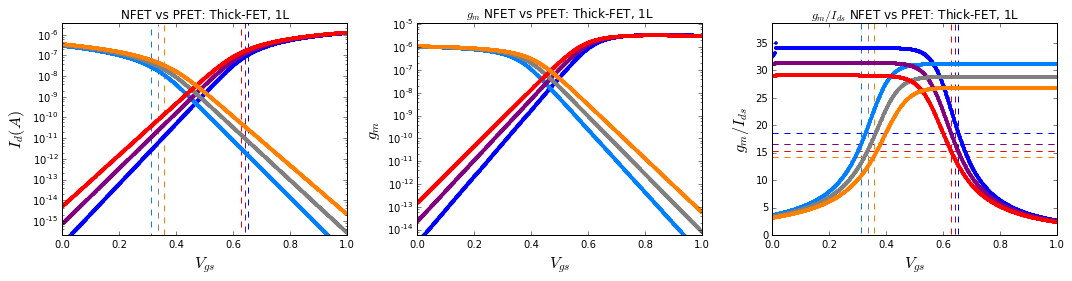

In [470]:
figsize(15,4)
Vths_N_eg1L, IS_N_eg1L, Vths_P_eg1L, IS_P_eg1L = compareFETs(("NFET_eg1L", "PFET_eg1L"), 
            (folderRoot, folderRoot_P),
            "NFET vs PFET: Thick-FET, 1L",
            curveType="IdsVgsCurve")

#### Long Channel (1Txr, 450nm)

Temp: 0.0 	Vds: 0.012
/home/noza/work/Braindrop/CDB/BDTests/NFET_test/IV_Sim_Results/ParamExtract/NFET_eg3L_IdsVgsCurve_Vds0.012.csv
/home/noza/work/Braindrop/CDB/BDTests/PFET_test/IV_Sim_Results/ExtractParams/PFET_eg3L_IdsVgsCurve_Vds0.012.csv
Temp: 25.0 	Vds: 0.013
/home/noza/work/Braindrop/CDB/BDTests/NFET_test/IV_Sim_Results/ParamExtract/NFET_eg3L_IdsVgsCurve_Vds0.013.csv
/home/noza/work/Braindrop/CDB/BDTests/PFET_test/IV_Sim_Results/ExtractParams/PFET_eg3L_IdsVgsCurve_Vds0.013.csv
Temp: 50.0 	Vds: 0.014
/home/noza/work/Braindrop/CDB/BDTests/NFET_test/IV_Sim_Results/ParamExtract/NFET_eg3L_IdsVgsCurve_Vds0.014.csv
/home/noza/work/Braindrop/CDB/BDTests/PFET_test/IV_Sim_Results/ExtractParams/PFET_eg3L_IdsVgsCurve_Vds0.014.csv
Vth ( NFET_eg3L ): [0.65800000000000047, 0.64700000000000046, 0.63100000000000045] 
Vth ( PFET_eg3L ): [0.30500000000000022, 0.32900000000000018, 0.35200000000000031]
IS ( NFET_eg3L ): [4.5339835562226938e-08, 5.3500456931882252e-08, 5.6736093139150413e-08] 
IS (

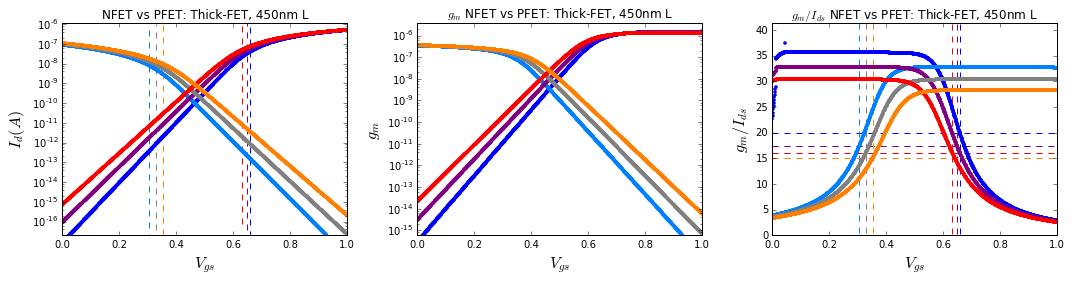

In [453]:
figsize(15,4)
Vths_N_eg3L, IS_N_eg3L, Vths_P_eg3L, IS_P_eg3L = compareFETs(("NFET_eg3L", "PFET_eg3L"), 
            (folderRoot, folderRoot_P),
            "NFET vs PFET: Thick-FET, 450nm L",
            curveType="IdsVgsCurve")

Note: The specific currents for a longer channel device aren't exactly 3 times smaller than the specific current of the smaller devices above.  Why is this the case?

### Thin-Oxide

Temp: 0.0 	Vds: 0.012
Temp: 25.0 	Vds: 0.013
Temp: 50.0 	Vds: 0.014
Vth ( NFET_1L ): [0.51400000000000035, 0.50800000000000034, 0.50100000000000033] 
Vth ( PFET_1L ): [0.35100000000000031, 0.37300000000000028, 0.4000000000000003]
IS ( NFET_1L ): [3.8723216464001473e-07, 4.4330817789349527e-07, 4.9835851290818388e-07] 
IS ( PFET_1L ): [1.1383008271093398e-07, 1.428885411127493e-07, 1.6428249810338002e-07]


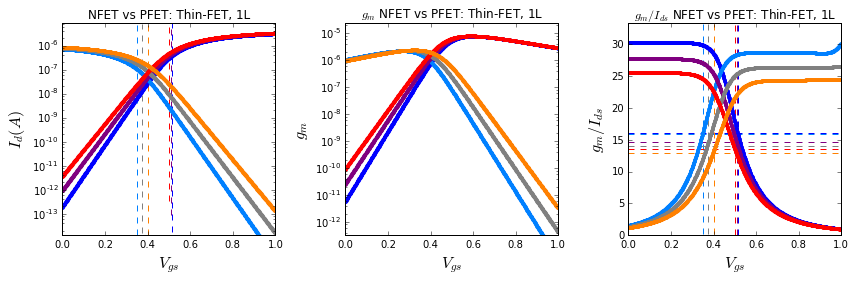

In [502]:
figsize(12,4)
Vths_N_1L, IS_N_1L, Vths_P_1L, IS_P_1L = compareFETs(("NFET_1L", "PFET_1L"), 
            (folderRoot, folderRoot_P),
            "NFET vs PFET: Thin-FET, 1L",
            curveType="IdsVgsCurve")

## Plot slope factor $n$ ($\frac{1}{\kappa}$)

_Note: the mean, min, and max values shown are for the full measured range of values and not for the region that is being viewed using xLims()_
### Short-channel (150nm)

#### Thick-Oxide Slope Factor plots

------------NFET ThickOx 1L------------
Temp:  0.0
Mean SFs: 1.11082097778 	Mean kappa: 0.900239552785
Min SFs: 1.10778706244 	Min kappa: 0.896140206795
Max SFs: 1.11589681215 	Max kappa: 0.902700558532
Temp:  25.0
Mean SFs: 1.11142042621 	Mean kappa: 0.899754732819
Min SFs: 1.10819126602 	Min kappa: 0.895282653128
Max SFs: 1.11696568286 	Max kappa: 0.902371305989
Temp:  50.0
Mean SFs: 1.11204011524 	Mean kappa: 0.899254012013
Min SFs: 1.10864371741 	Min kappa: 0.894449502849
Max SFs: 1.11800609963 	Max kappa: 0.902003036955
Fitted Gammas: [ 0.99182719  0.96426215  0.94502753]
Fitted V_fermis: [ 9.77747893  9.1282316   8.66022216]
None


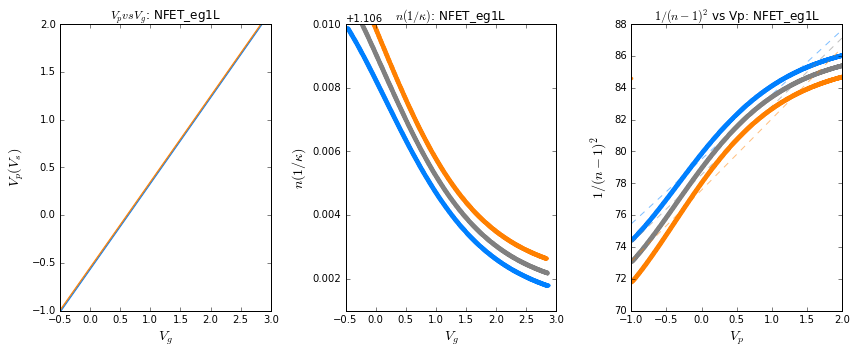

------------PFET ThickOx 1L------------
Temp:  0.0
Mean SFs: 1.12089476354 	Mean kappa: 0.892144487524
Min SFs: 1.12058870212 	Min kappa: 0.891349128422
Max SFs: 1.12189485367 	Max kappa: 0.892388079683
Temp:  25.0
Mean SFs: 1.1209994116 	Mean kappa: 0.892061219353
Min SFs: 1.12066301181 	Min kappa: 0.891190014625
Max SFs: 1.1220951577 	Max kappa: 0.892328906606
Temp:  50.0
Mean SFs: 1.1211342992 	Mean kappa: 0.891953910975
Min SFs: 1.12076748949 	Min kappa: 0.89100155183
Max SFs: 1.12233250093 	Max kappa: 0.892245723913
Fitted Gammas: [ 26.91913034  27.42093616  28.54389324]
Fitted V_fermis: [ 6197.12064843  6419.20518081  6940.30125781]
None


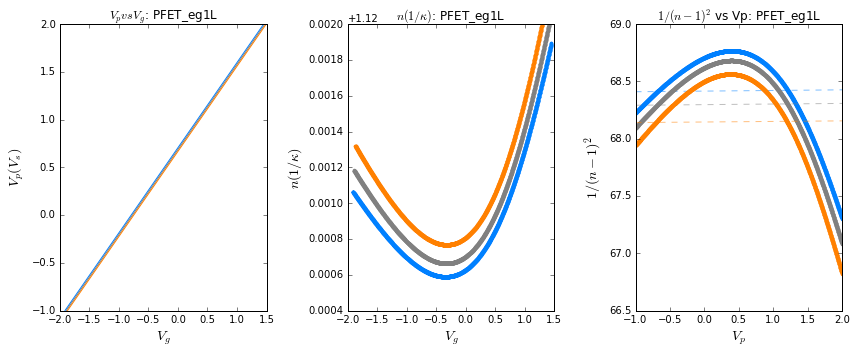

In [30]:
SFs,gammas,fermis = slopeFactor(folderRoot, FETType="NFET", curveType="VgvsVs_KappaExtraction",
                  #temps=temps, xLims=(0,1), yLims=(1.11, 1.12), printFN=True)
                  temps=temps, ttl="NFET_eg1L", xLims=None, yLims=None, printFN=False, plotIdx=1)
print "------------NFET ThickOx 1L------------\n", printSFInfo(temps,SFs,gammas,fermis)
show()
SFs,gammas,fermis = slopeFactor(folderRoot_P, FETType="PFET", curveType="VgvsVs_KappaExtraction",
                  temps=temps, ttl="PFET_eg1L", xLims=None, yLims=None,plotIdx=1)
print "------------PFET ThickOx 1L------------\n", printSFInfo(temps,SFs,gammas,fermis)

#### Thin-Oxide Slope Factor plots

------------NFET ThinOx 1L------------
Temp:  0.0
Mean SFs: 1.05144484581 	Mean kappa: 0.951072355093
Min SFs: 1.050719291 	Min kappa: 0.950552098653
Max SFs: 1.0520201906 	Max kappa: 0.951728980868
Temp:  25.0
Mean SFs: 1.05155430109 	Mean kappa: 0.950973363578
Min SFs: 1.05081391938 	Min kappa: 0.950443227937
Max SFs: 1.05214069668 	Max kappa: 0.951643275332
Temp:  50.0
Mean SFs: 1.05169019786 	Mean kappa: 0.950850483457
Min SFs: 1.05066553506 	Min kappa: 0.950316211498
Max SFs: 1.05228132268 	Max kappa: 0.951777674844
Fitted Gammas: [ 19.89560678  19.91683836  20.01698473]
Fitted V_fermis: [ 18697.17192509  18657.79849206  18746.97836674]
None


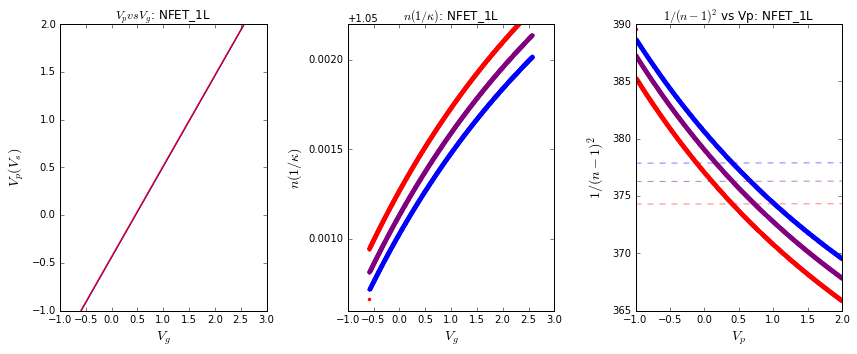

------------PFET ThinOx 1L------------
Temp:  0.0
Mean SFs: 1.06284007082 	Mean kappa: 0.940875433341
Min SFs: 1.06248353883 	Min kappa: 0.940185470385
Max SFs: 1.06361992553 	Max kappa: 0.941191052339
Temp:  25.0
Mean SFs: 1.06318807059 	Mean kappa: 0.940567470832
Min SFs: 1.06283244443 	Min kappa: 0.939862249861
Max SFs: 1.06398570657 	Max kappa: 0.940882079056
Temp:  50.0
Mean SFs: 1.06362303266 	Mean kappa: 0.940182825296
Min SFs: 1.06328066159 	Min kappa: 0.939487750135
Max SFs: 1.06440983382 	Max kappa: 0.940485458
Fitted Gammas: [ 1.12818827  1.1371006   1.17473689]
Fitted V_fermis: [ 40.04434977  40.2338985   42.36908488]
None
Hello


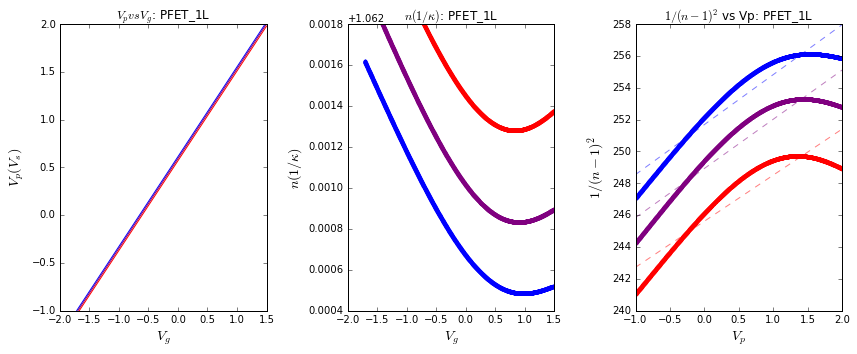

In [29]:
SFs,gammas,fermis = slopeFactor(folderRoot, FETType="NFET", curveType="VgvsVs_KappaExtraction",
                  #temps=temps, xLims=(0,1), yLims=(1.11, 1.12), printFN=True)
                  temps=temps, ttl="NFET_1L", xLims=None, yLims=None, printFN=False, plotIdx=0)
print "------------NFET ThinOx 1L------------\n", printSFInfo(temps,SFs,gammas,fermis)
show()
SFs,gammas,fermis = slopeFactor(folderRoot_P, FETType="PFET", curveType="VgvsVs_KappaExtraction",
                  temps=temps, ttl="PFET_1L", xLims=None, yLims=None, printFN=False, plotIdx=0)
print "------------PFET ThinOx 1L------------\n", printSFInfo(temps,SFs,gammas,fermis)
print "Hello"

### Long-channel (450nm), Thick-Oxide

------------NFET ThickOx 3L------------
Temp:  0.0
Mean SFs: 1.10972110459 	Mean kappa: 0.901127903645
Min SFs: 1.10888760856 	Min kappa: 0.899366020538
Max SFs: 1.11189435354 	Max kappa: 0.901804648447
Temp:  25.0
Mean SFs: 1.11027389969 	Mean kappa: 0.900679365574
Min SFs: 1.10935566952 	Min kappa: 0.898727741182
Max SFs: 1.11268402451 	Max kappa: 0.901424157709
Temp:  50.0
Mean SFs: 1.11081804597 	Mean kappa: 0.900238278786
Min SFs: 1.10602719565 	Min kappa: 0.898125457973
Max SFs: 1.11343019076 	Max kappa: 0.904136900009
Fitted Gammas: [ 1.66010701  1.5945729   1.54982836]
Fitted V_fermis: [ 28.37146259  25.89333355  24.20572936]
None


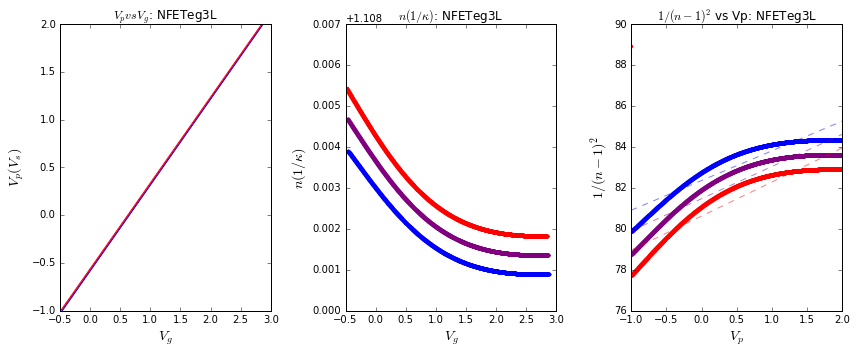

------------PFET ThickOx 3L------------
Temp:  0.0
Mean SFs: 1.12370931478 	Mean kappa: 0.889909963887
Min SFs: 1.12336075737 	Min kappa: 0.888988176817
Max SFs: 1.12487435275 	Max kappa: 0.890185982943
Temp:  25.0
Mean SFs: 1.12380196667 	Mean kappa: 0.889836618184
Min SFs: 1.12341987289 	Min kappa: 0.888822084762
Max SFs: 1.12508455533 	Max kappa: 0.890139140436
Temp:  50.0
Mean SFs: 1.12390856235 	Mean kappa: 0.889752250282
Min SFs: 1.12349101048 	Min kappa: 0.888638551192
Max SFs: 1.1253169229 	Max kappa: 0.890082778298
Fitted Gammas: [ 29.23417472  30.66843596  32.15863504]
Fitted V_fermis: [ 6980.10209972  7670.39327508  8419.49697177]
None


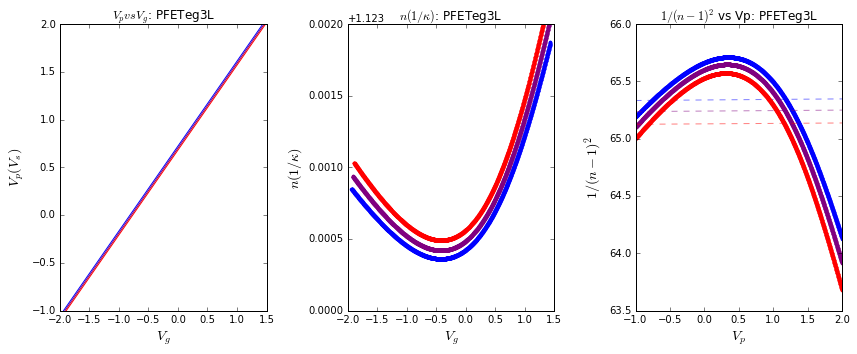

In [16]:
figsize(12,5)
SFs,gammas,fermis = slopeFactor(folderRoot, FETType="NFETeg3L", curveType="VgvsVs_KappaExtraction",
                  temps=temps, xLims=None, yLims=(1.108, 1.115))
print "------------NFET ThickOx 3L------------\n", printSFInfo(temps,SFs,gammas,fermis)
show()
SFs,gammas,fermis = slopeFactor(folderRoot_P, FETType="PFETeg3L", curveType="VgvsVs_KappaExtraction",
                  temps=temps, xLims=None, yLims=(1.123, 1.125))
print "------------PFET ThickOx 3L------------\n", printSFInfo(temps,SFs,gammas,fermis)

## Find and Plot the Early Voltages

In [ ]:
threshold = 0.6

figsize(12,10)
subplot(2,2,1)
ev_Vds, ev_Ids, EarlyVoltages, Ms, Bs = getEarlyVoltages(origVds_1L, origIds_1L_Vds, threshold)
plotIds((origVds_1L, origIds_1L_Vds), ttl="Thin-FET, 1L, Varying $V_{gs}$", xlbl='$V_{ds}$')
plotEarlyVTheory(ev_Vds, Ms, Bs, -4)

subplot(2,2,2)
ev_Vds, ev_Ids, EarlyVoltages, Ms, Bs = getEarlyVoltages(origVds_3L, origIds_3L_Vds, threshold)
plotIds((origVds_3L, origIds_3L_Vds), ttl="Thin-FET, 3L, Varying $V_{gs}$", xlbl='$V_{ds}$')
plotEarlyVTheory(ev_Vds, Ms, Bs, -6)

subplot(2,2,3)
ev_Vds, ev_Ids, EarlyVoltages, Ms, Bs = getEarlyVoltages(origVds_eg1L, origIds_eg1L_Vds, threshold)
plotIds((origVds_eg1L, origIds_eg1L_Vds), ttl="Thick-FET, 1L, Varying $V_{gs}$", xlbl='$V_{ds}$')
plotEarlyVTheory(ev_Vds, Ms, Bs, -10)

subplot(2,2,4)
ev_Vds, ev_Ids, EarlyVoltages, Ms, Bs = getEarlyVoltages(origVds_eg3L, origIds_eg3L_Vds, threshold)
plotIds((origVds_eg3L, origIds_eg3L_Vds), ttl="Thick-FET, 3L, Varying $V_{gs}$", xlbl='$V_{ds}$')
plotEarlyVTheory(ev_Vds, Ms, Bs, -16)

tight_layout()
show()

# Appendix

## Test  plotting of slope factors and extracting parameters

### Using actual data

/home/noza/work/Braindrop/CDB/BDTests/NFET_test/IV_Sim_Results/ParamExtract/NFET_VgvsVs_KappaExtraction_T0C.csv
Fitted Gamma: 0.845006695541 	 Fitted V_fermi: 7.13066949677
/home/noza/work/Braindrop/CDB/BDTests/NFET_test/IV_Sim_Results/ParamExtract/NFET_VgvsVs_KappaExtraction_T25C.csv
Fitted Gamma: 0.818758900172 	 Fitted V_fermi: 6.61675430316
/home/noza/work/Braindrop/CDB/BDTests/NFET_test/IV_Sim_Results/ParamExtract/NFET_VgvsVs_KappaExtraction_T50C.csv
Fitted Gamma: 0.800330513411 	 Fitted V_fermi: 6.24774072095


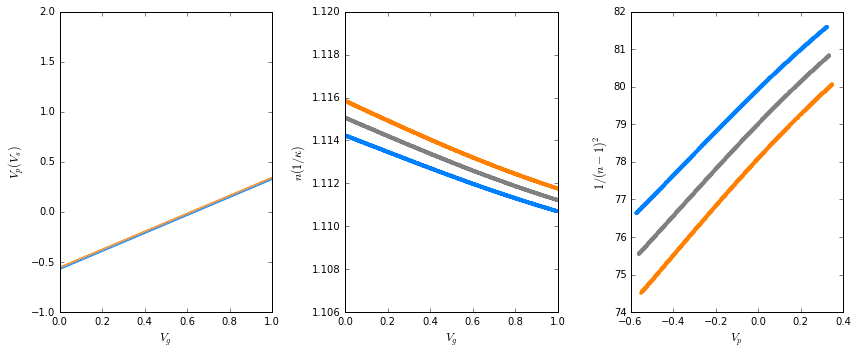

In [794]:
#from scipy.optimize import least_squares
FETType = "NFET"
curveType = "VgvsVs_KappaExtraction"
for i, curTemp in enumerate(temps):
    j=1
    Vps, Vgs = getData(folderRoot, FETType=FETType,
                                            CurveType=curveType, IDVal="T"+str(int(curTemp))+"C", printFN=True)
    subplot(1,3,1)
    #plotVpvsVg((Vgs[mask[:,i],2], Vps[mask[:,i],i]))
    plotVpvsVg((Vgs[:,2], Vps[:,i]),color=(1.*i/(numTemps-1), 1.*j/(numTemps-1), 1-(1.*i/(numTemps-1))))
    xlim((0,1))
    subplot(1,3,2)
    SFs = plotSlopeFactor((Vgs[:,2], Vps[:,i]),color=(1.*i/(numTemps-1), 1.*j/(numTemps-1), 1-(1.*i/(numTemps-1))))
    xlim((0,1))
    subplot(1,3,3)
    mask = where((Vgs[:,2]>=0)*(Vgs[:,2]<1))[0]
    #print "AAA", len(mask), mask
    #print "BBB", len(Vps[mask,i]), Vps[mask,i]
    #print "CCC", len(SFs[mask]), min(SFs[mask]), max(SFs[mask])
    gamma, vFermi = getSFParams(Vps[mask,i], calcInvNOffSq(SFs)[mask], (0.5, 0.2))
    invNOffSq = plotSFParamData((Vps[mask,i], SFs[mask]),color=(1.*i/(numTemps-1), 1.*j/(numTemps-1), 1-(1.*i/(numTemps-1))))
    #print invNOffSq
    #gamma, vFermi = getSFParams(Vps[mask,i], invNOffSq, (0.201, -10.1))
tight_layout()

### Using fabricated data

Fitted Gamma: 1.5 	 Fitted V_fermi: 0.325
[ 81.  81.  81.  81.  81.  81.  81.  81.  81.  81.  81.  81.  81.  81.  81.
  81.  81.  81.  81.  81.  81.  81.  81.  81.  81.  81.  81.  81.  81.  81.
  81.  81.  81.  81.  81.  81.  81.  81.  81.  81.  81.  81.  81.  81.  81.
  81.  81.  81.  81.  81.  81.  81.  81.  81.  81.  81.  81.  81.  81.  81.
  81.  81.  81.  81.  81.  81.  81.  81.  81.  81.  81.  81.  81.  81.  81.
  81.  81.  81.  81.  81.  81.  81.  81.  81.  81.  81.  81.  81.  81.  81.
  81.  81.  81.  81.  81.  81.  81.  81.  81.  81.]
Fitted Gamma: 7.48394249381 	 Fitted V_fermi: 567.094739981


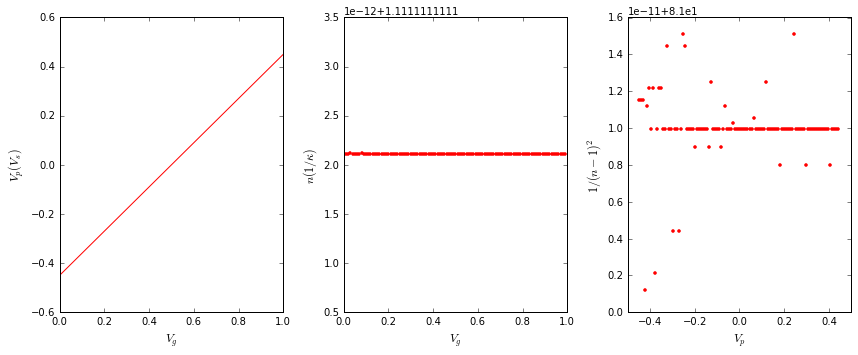

In [807]:
fooVgs = linspace(0,1,101)
fooVps = 0.9*(fooVgs-0.5)
#bar = linspace(1.1, 1.05, 101)
#print fooVgs, fooVps

# This is fake data testing to see if the leastsq algorithm is working
fooInvNSq = SFParamEq(fooVps, 1.5, 0.325)
#print fooInvNSq
#print ((1./fooInvNSq)**0.5)+1
fooGamma, fooFermiV = getSFParams(fooVps, fooInvNSq, (0.5, 0.2))

subplot(1,3,1)
plotVpvsVg((fooVgs, fooVps))
subplot(1,3,2)
fooSFs = plotSlopeFactor((fooVgs, fooVps))
#print fooSFs
subplot(1,3,3)
fooYs = plotSFParamData((fooVps[:-1], fooSFs))
print fooYs
fooGamma, fooFermiV = getSFParams(fooVps[:-1], fooYs, (0.04, 0.3))
tight_layout()

## Test getIVal and getVVal methods

In [443]:
for a in arange(3):
    curveType = "IdsVgsCurve"
    FETType = "PFET_eg1L"
    xVals, yVals = getData(folderRoot_P, FETType=FETType,
                                            CurveType=curveType, IDVal="Vds"+str(Vds[a]))

    print IS_P_eg1L[a]/1.13, IS_P_eg1L[a], temps[a], Vds[a]
    Vgs = getVVal(IS_P_eg1L[a]/1.13, xVals[:,a], yVals[:,a])
    Id = getIVal(Vgs, xVals[:,a], yVals[:,a])
    print Vgs, Id*1.13

#    FETType = "NFET_eg1L"
#    xVals, yVals = getData(folderRoot, FETType=FETType,
#                                            CurveType=curveType, IDVal="Vds"+str(Vds[a]))
#    print IS_N_eg1L[a]/1.13, IS_N_eg1L[a], temps[a], Vds[a]
#    Vgs = getVVal(array(IS_N_eg1L[a])/1.13, xVals[:,a], yVals[:,a])
#    Id = getIVal(Vgs, xVals[:,a], yVals[:,a])
#    print Vgs, Id

/home/noza/work/Braindrop/CDB/BDTests/PFET_test/IV_Sim_Results/ExtractParams/PFET_eg1L_IdsVgsCurve_Vds0.012.csv
2.7455856672e-08 3.10251180393e-08 0.0 0.012
0.312 3.10251180393e-08
/home/noza/work/Braindrop/CDB/BDTests/PFET_test/IV_Sim_Results/ExtractParams/PFET_eg1L_IdsVgsCurve_Vds0.013.csv
3.06940287421e-08 3.46842524786e-08 25.0 0.013
0.334 3.46842524786e-08
/home/noza/work/Braindrop/CDB/BDTests/PFET_test/IV_Sim_Results/ExtractParams/PFET_eg1L_IdsVgsCurve_Vds0.014.csv
3.36264050904e-08 3.79978377521e-08 50.0 0.014
0.356 3.79978377521e-08


## Print permutations of Vds and temp sweeps to get all values
Print all permutations of Vds and temp sweeps to ensure I'm grabbing the correct values from my CompareFETs sweep

Note: I am!! :-D

[0.65300000000000047, 0.64100000000000046, 0.62600000000000044]
[1.2139880527590557e-07, 1.3843537536339645e-07, 1.4828965266114836e-07]
Vd: 0.012
/home/noza/work/Braindrop/CDB/BDTests/PFET_test/IV_Sim_Results/ExtractParams/PFET_eg1L_IdsVgsCurve_Vds0.012.csv
Temp: 0.0
Vt( 0.0 ):  0.312
IS( 0.0 ):  2.7455856672e-08 3.10251180393e-08
Temp: 25.0
Vt( 25.0 ):  0.335
IS( 25.0 ):  2.81387050753e-08 3.1796736735e-08
Temp: 50.0
Vt( 50.0 ):  0.357
IS( 50.0 ):  2.88675714894e-08 3.2620355783e-08


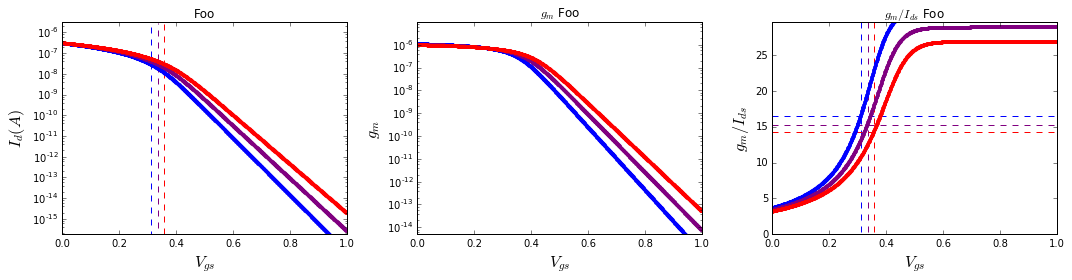

Vd: 0.013
/home/noza/work/Braindrop/CDB/BDTests/PFET_test/IV_Sim_Results/ExtractParams/PFET_eg1L_IdsVgsCurve_Vds0.013.csv
Temp: 0.0
Vt( 0.0 ):  0.311
IS( 0.0 ):  2.99655153546e-08 3.38610323507e-08
Temp: 25.0
Vt( 25.0 ):  0.334
IS( 25.0 ):  3.06940287421e-08 3.46842524786e-08
Temp: 50.0
Vt( 50.0 ):  0.356
IS( 50.0 ):  3.14736313472e-08 3.55652034224e-08


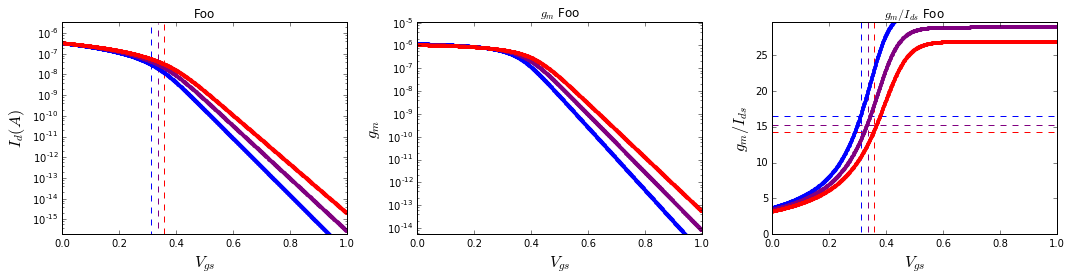

Vd: 0.014
/home/noza/work/Braindrop/CDB/BDTests/PFET_test/IV_Sim_Results/ExtractParams/PFET_eg1L_IdsVgsCurve_Vds0.014.csv
Temp: 0.0
Vt( 0.0 ):  0.311
IS( 0.0 ):  3.19734682756e-08 3.61300191514e-08
Temp: 25.0
Vt( 25.0 ):  0.333
IS( 25.0 ):  3.32825606139e-08 3.76092934937e-08
Temp: 50.0
Vt( 50.0 ):  0.356
IS( 50.0 ):  3.36264050904e-08 3.79978377521e-08


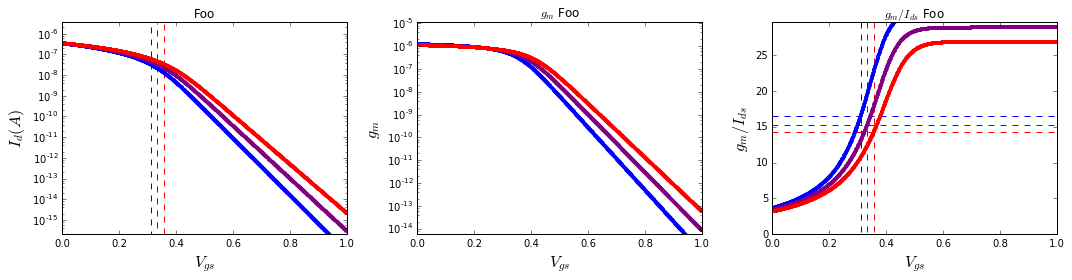

In [444]:
print Vths_N_eg1L
print IS_N_eg1L
FETType = "PFET_eg1L"
curveType = "IdsVgsCurve"


for j, Vd in enumerate(Vds):
    print "Vd:", Vd
    xVals, yVals = getData(folderRoot_P, FETType=FETType,
                                            CurveType=curveType, IDVal="Vds"+str(Vd))
    numTemps = shape(yVals)[1]
    for i, temp in enumerate(temps):
        print "Temp:", temp
        curVgs = xVals[:,i]
        curIds = yVals[:,i]
        #print curIds
        curGms = calcGm(curVgs, curIds)
        #print curGms
        curGmOverId = calcGmOverId(curGms, curIds[:-1])
        #print calcGmOverId(curGms, curIds[:-1])
        
        Vth, halfGmOverId  = calcVth(curVgs, curGmOverId)
        print "Vt(", temp,"): ", Vth
        curIS = calcIS(Vth, curVgs, curIds)[0]
        print "IS(",temp,"): ", curIS/1.13, curIS
        a, b, c, d = plotVgPlots(curVgs, curIds, "Foo", 
                    color=(1.*i/(numTemps-1), 0, 1-(1.*i/(numTemps-1))))
    show()

## Fit the subthreshold region for parameters

In [ ]:
temp = 25
print Vds
print xData
print yData

popt, pcov = leastsq(Ids_NFET_Err, (0.7, 0.6, -9, 0.05), args=(xData, yData, Vds, temp))
kappa = popt[0]
gam = popt[1]
Kd = popt[2]
lamda = popt[3]